In [2]:
#pip install yfinance

In [4]:
#pip install pmdarima

In [7]:
import os
import warnings
warnings.filterwarnings("ignore")

import yfinance as yf

import numpy as np
import pandas as pd

import pywt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm 
from scipy import signal
from sklearn.decomposition import PCA

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from datetime import datetime

#from google.colab import drive
#drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


# 0.utils

In [8]:
def load_stockindex_(indexname=None):
  # note:
  stockindex = yf.Ticker(indexname)
  stockindex_hist = stockindex.history(start='2014-01-01',end='2020-12-31')
  stockindex_hist.index=pd.to_datetime(stockindex_hist.index.date)
  stockindex_hist.index = pd.DatetimeIndex(stockindex_hist.index).to_period('D')
  return stockindex_hist[['Close']]

In [9]:
def logreturn_(arr_):
  # note:
  logreturn = np.diff(np.log(arr_))
  return logreturn

In [10]:
def holdtest_split_(df,test_start='2020-01-01',test_end='2020-12-31'):
  # note:
  df_holdout=df[df.index<test_start]
  df_test=df[(df.index>=test_start)&(df.index<=test_end)]
  return df_holdout,df_test

In [11]:
def load_sentiment_(test_end='2020-12-31'):
  # note:
  filename = "../data/ARIMA-RNN/df_overall_sentiment_2014_2020.csv"
  df=pd.read_csv(filename)
  df=df[df['timestamp']<=test_end]
  df.index=df['timestamp']
  
  df.index=pd.to_datetime(df.index)
  df.index = pd.DatetimeIndex(df.index).to_period('D')

  return df[['overall_sentiment']]

In [12]:
def load_CLS_(dim_emb):
  # note:
  pca=PCA(n_components=dim_emb)

  df1=pd.read_csv('../data/ARIMA-RNN/pooled_aggregated_CLS_training_2015_2019_Weighted.csv')
  df1_tmp=pd.DataFrame()
  df1_tmp['Date']=df1['timestamp']
  df1_tmp[['p'+str(x) for x in range(dim_emb)]]=pca.fit_transform(np.array(df1.drop(['timestamp'],axis=1)))

  df2=pd.read_csv('../data/ARIMA-RNN/pooled_aggregated_CLS_test_2020.csv')
  df2_tmp=pd.DataFrame()
  df2_tmp['Date']=df2['Date']
  df2_tmp[['p'+str(x) for x in range(dim_emb)]]=pca.transform(np.array(df2.drop(['Date'],axis=1)))

  df=pd.concat([df1_tmp,df2_tmp],axis=0)
  df.index=df['Date']
  df.index=pd.to_datetime(df.index)
  df.index = pd.DatetimeIndex(df.index).to_period('D')
  df=df.drop(['Date'],axis=1)
  return df

In [13]:
def eval_(y_pred,y_true,method='mae',vis=True):
  # note:
  if vis:
    plt.rcParams["figure.figsize"] = (15,5)
    plt.plot(y_true,color='b',label='y_true')
    plt.plot(y_pred,color='r',label='y_pred')
    plt.ylabel('stock index')
    plt.xlabel('time')
    plt.legend(loc='upper right')
    plt.show()

  if method=='mae':
    return ('MAE',round(mean_absolute_error(np.array(y_true).reshape(-1), 
                                     np.array(y_pred).reshape(-1)),4))
  elif method=='mse':
    return ('MSE',round(mean_squared_error(np.array(y_true).reshape(-1), 
                                    np.array(y_pred).reshape(-1)),4))

# 1.Persistance model

In [14]:
def persistance_(data_target):
  # note:
  y_true=np.array(data_target).reshape(-1)[1:]
  y_pred=np.array(data_target).reshape(-1)[:-1]
  return y_pred,y_true

## 1.1 S&P 500

==================S&P 500 2020.01.01 to 2020.12.31====================


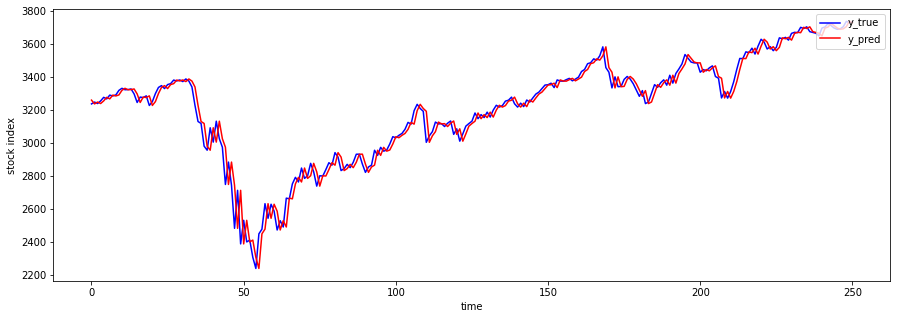

('MAE', 40.722)

In [ ]:
## pipeline----------------------
data=load_stockindex_('^GSPC')
df_train,df_test=holdtest_split_(data)
y_pred,y_true_500=persistance_(df_test)

print('==================S&P 500 2020.01.01 to 2020.12.31====================')
eval_(y_pred,y_true_500)

## 1.2 Dow Jones Industrial

==================Dow Jones Industrial 2020.01.01 to 2020.12.31====================


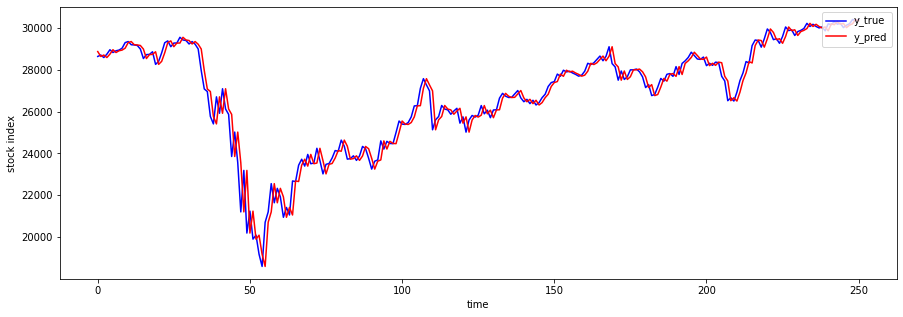

('MAE', 358.0027)

In [15]:
## pipeline----------------------
data=load_stockindex_('^DJI')
df_train,df_test=holdtest_split_(data)
y_pred,y_true_225=persistance_(df_test)

print('==================Dow Jones Industrial 2020.01.01 to 2020.12.31====================')
eval_(y_pred,y_true_225)

## 1.3 Nasdaq Composite

==================Nasdaq 2020.01.01 to 2020.12.31====================


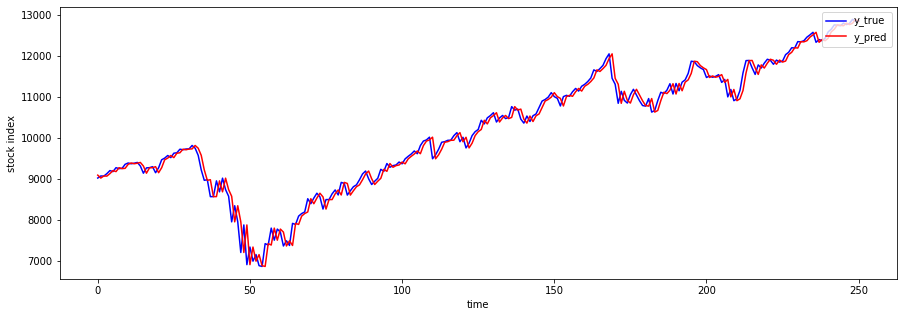

('MAE', 140.8866)

In [ ]:
## pipeline----------------------
data=load_stockindex_('^IXIC')
df_train,df_test=holdtest_split_(data)
y_pred,y_true_com=persistance_(df_test)

print('==================Nasdaq 2020.01.01 to 2020.12.31====================')
eval_(y_pred,y_true_com)

# 2.ARIMA model

In [16]:
def ARIMA_(endog_=None,exog_=None):
  # note: 
  endog_=np.array(endog_).reshape(-1,1)

  if exog_ is None:
    m=pm.auto_arima(y=endog_,X=None,error_action='ignore',suppress_warnings=True,maxiter=5)
  else:
    exog_=np.array(exog_).reshape(-1,1)
    m=pm.auto_arima(y=endog_,X=exog_,error_action='ignore',suppress_warnings=True,maxiter=5)
  return m

In [17]:
def ARIMApipe_(test_startindex=None,withexog=False):
  # note:
  pred_list=[]
  true_list=[]

  for i in range(-test_startindex):

    if withexog is True:
      train_logreturn=arr_logreturn[test_startindex-50:test_startindex]
      train_sentiment=arr_sentiment[test_startindex-50:test_startindex]
      m=ARIMA_(train_logreturn,train_sentiment)
      #np.log(t1/t0)=logreturn  t1=e^logreturn*t0
      pred_logreturn=m.predict(1,X=np.array([train_sentiment[-1]]).reshape(-1,1))[0]
      pred_=np.exp(pred_logreturn)*arr[test_startindex-1]
      pred_list.append(pred_)

    else:
      train_logreturn=arr_logreturn[test_startindex-50:test_startindex]
      m=ARIMA_(train_logreturn)
      #np.log(t1/t0)=logreturn  t1=e^logreturn*t0
      pred_logreturn=m.predict(1)[0]
      pred_=np.exp(pred_logreturn)*arr[test_startindex-1]
      pred_list.append(pred_)

    true_list.append(arr[test_startindex])
    test_startindex+=1

  return pred_list,true_list

## 2.1 S&P 500

In [ ]:
data=load_stockindex_('^GSPC')
train_,test_=holdtest_split_(data)
train_,test_=np.array(train_).reshape(-1),np.array(test_).reshape(-1)

test_startindex=-len(test_)
arr=np.concatenate([train_,test_],axis=0)
arr_logreturn=logreturn_(arr)

arr_sentiment=np.array(pd.merge(data, load_sentiment_(), 
                       how='left',left_index=True, right_index=True)['overall_sentiment'])

==================S&P 500 2020.01.01 to 2020.12.31 (without sentiment)====================


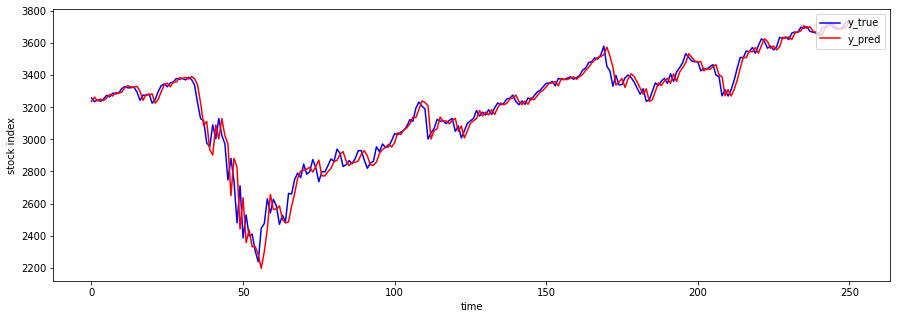

('MAE', 42.0857)

In [ ]:
pred_list,true_list=ARIMApipe_(test_startindex,False)

#----------------------------------------------
print('==================S&P 500 2020.01.01 to 2020.12.31 (without sentiment)====================')
pred_arima_500=pred_list
eval_(pred_list,true_list) 

==================S&P 500 2020.01.01 to 2020.12.31 (with sentiment)====================


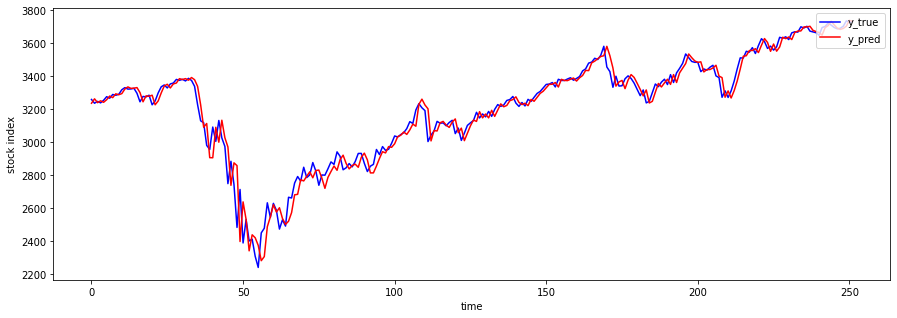

('MAE', 41.7337)

In [ ]:
pred_list,true_list=ARIMApipe_(test_startindex,True)

#----------------------------------------------
print('==================S&P 500 2020.01.01 to 2020.12.31 (with sentiment)====================')
eval_(pred_list,true_list) 

## 2.2 Dow Jones Industrial

In [18]:
data=load_stockindex_('^DJI')
train_,test_=holdtest_split_(data)
train_,test_=np.array(train_).reshape(-1),np.array(test_).reshape(-1)

test_startindex=-len(test_)
arr=np.concatenate([train_,test_],axis=0)
arr_logreturn=logreturn_(arr)

arr_sentiment=np.array(pd.merge(data, load_sentiment_(), 
                       how='left',left_index=True, right_index=True)['overall_sentiment'])

==================Dow Jones Industrial 2020.01.01 to 2020.12.31 (without sentiment)====================


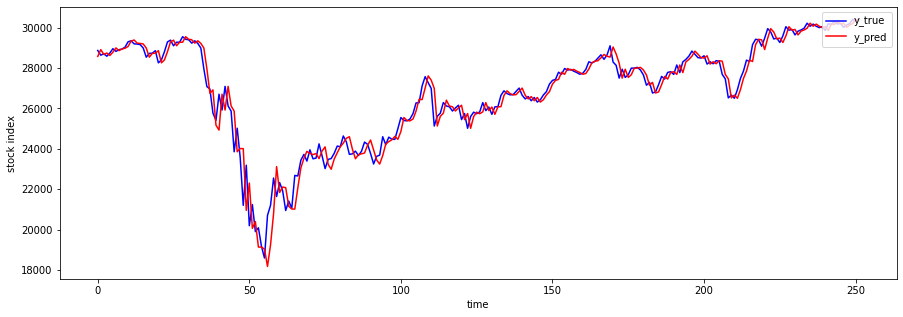

('MAE', 364.127)

In [19]:
pred_list,true_list=ARIMApipe_(test_startindex,False)

#----------------------------------------------
print('==================Dow Jones Industrial 2020.01.01 to 2020.12.31 (without sentiment)====================')
pred_arima_225=pred_list
eval_(pred_list,true_list) 

==================Dow Jones Industrial 2020.01.01 to 2020.12.31 (with sentiment)====================


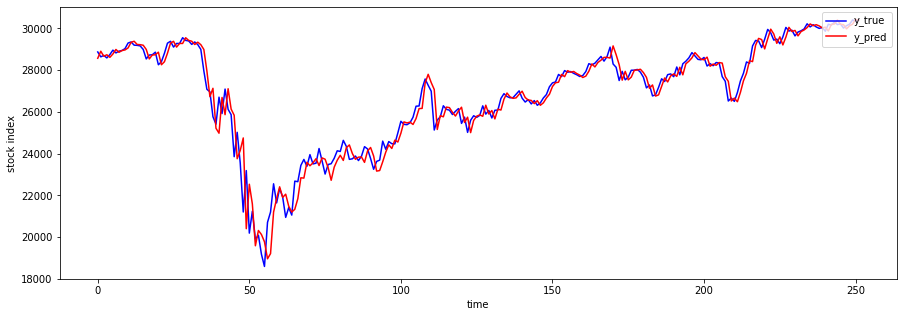

('MAE', 368.1016)

In [20]:
pred_list,true_list=ARIMApipe_(test_startindex,True)

#----------------------------------------------
print('==================Dow Jones Industrial 2020.01.01 to 2020.12.31 (with sentiment)====================')
eval_(pred_list,true_list) 

## 2.3 Nasdaq Composite

In [ ]:
data=load_stockindex_('^IXIC')
train_,test_=holdtest_split_(data)
train_,test_=np.array(train_).reshape(-1),np.array(test_).reshape(-1)

test_startindex=-len(test_)
arr=np.concatenate([train_,test_],axis=0)
arr_logreturn=logreturn_(arr)

arr_sentiment=np.array(pd.merge(data, load_sentiment_(), 
                       how='left',left_index=True, right_index=True)['overall_sentiment'])

==================Nasdaq 2020.01.01 to 2020.12.31 (without sentiment)====================


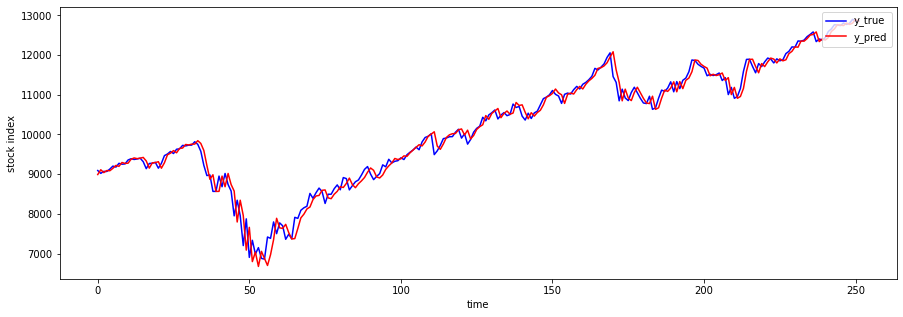

('MAE', 141.1237)

In [ ]:
pred_list,true_list=ARIMApipe_(test_startindex,False)

#----------------------------------------------
print('==================Nasdaq 2020.01.01 to 2020.12.31 (without sentiment)====================')
pred_arima_com=pred_list
eval_(pred_list,true_list) 

==================Nasdaq 2020.01.01 to 2020.12.31 (with sentiment)====================


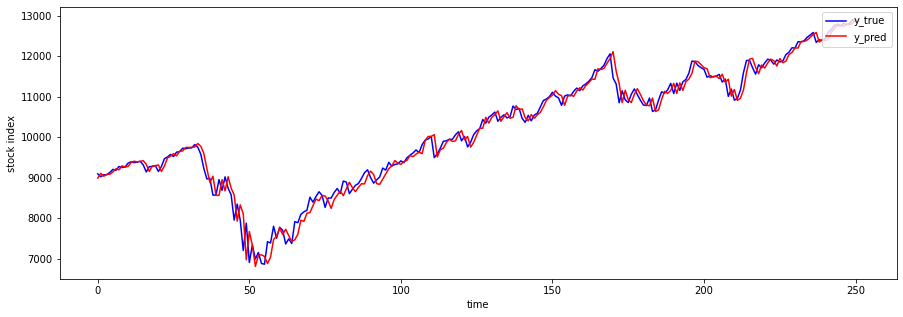

('MAE', 143.6411)

In [ ]:
pred_list,true_list=ARIMApipe_(test_startindex,True)

#----------------------------------------------
print('==================Nasdaq 2020.01.01 to 2020.12.31 (with sentiment)====================')
eval_(pred_list,true_list) 

# 3.Denoised-ARIMA model

In [23]:
def denoising_wavelet_(arr_,wavelet_,verbose=True):
  # ref: https://www.kaggle.com/code/theoviel/denoising-with-direct-wavelet-transform

  coeff = pywt.wavedec(arr_, wavelet_, mode="per")
  sigma = (1/0.6745) * np.mean(np.absolute(coeff[-1] - np.mean(coeff[-1])))
  uthresh = sigma * np.sqrt(2 * np.log(len(arr_)))
  coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
  arr_wavelet = pywt.waverec(coeff, wavelet_, mode='per')

  if verbose:
    plt.plot(arr_, label='before wavelet',color='b')
    plt.plot(arr_wavelet, label='after wavelet',color='g')
    plt.legend(loc='upper right')

  return arr_wavelet

In [24]:
def De_ARIMApipe_(test_startindex=None,withexog=False):
  pred_list=[]
  true_list=[]
  
  for i in range(-test_startindex):
    if withexog is True:
      train_logreturn=arr_logreturn[test_startindex-50:test_startindex]
      train_logreturn_denoised=denoising_wavelet_(train_logreturn,'db1',verbose=False)
      train_sentiment=arr_sentiment[test_startindex-50:test_startindex]
      m=ARIMA_(train_logreturn_denoised,train_sentiment)
      #np.log(t1/t0)=logreturn  t1=e^logreturn*t0
      pred_logreturn=m.predict(1,X=np.array([train_sentiment[-1]]).reshape(-1,1))[0]
      pred_=np.exp(pred_logreturn)*arr[test_startindex-1]
      pred_list.append(pred_)

    else:
      train_logreturn=arr_logreturn[test_startindex-50:test_startindex]
      train_logreturn_denoised=denoising_wavelet_(train_logreturn,'db1',verbose=False)
      m=ARIMA_(train_logreturn_denoised)
      #np.log(t1/t0)=logreturn  t1=e^logreturn*t0
      pred_logreturn=m.predict(1)[0]
      pred_=np.exp(pred_logreturn)*arr[test_startindex-1]
      pred_list.append(pred_)

    true_list.append(arr[test_startindex])
    test_startindex+=1

  return pred_list,true_list

## 3.1 S&P 500

In [ ]:
data=load_stockindex_('^GSPC')
train_,test_=holdtest_split_(data)
train_,test_=np.array(train_).reshape(-1),np.array(test_).reshape(-1)

test_startindex=-len(test_)
arr=np.concatenate([train_,test_],axis=0)
arr_logreturn=logreturn_(arr)

arr_sentiment=np.array(pd.merge(data, load_sentiment_(), 
                       how='left',left_index=True, right_index=True)['overall_sentiment'])

===========wavelet transform test part==========


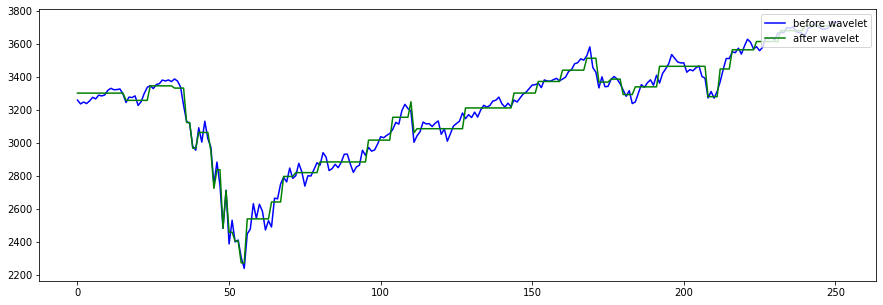

In [ ]:
# denoised example--
print('===========wavelet transform test part==========')
test_wave_true=denoising_wavelet_(test_,'db1')

==================S&P 500 2020.01.01 to 2020.12.31 (without sentiment)====================


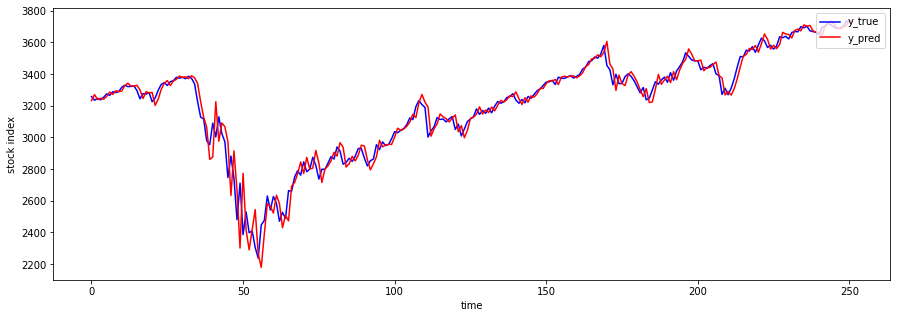

('MAE', 44.4689)

In [ ]:
pred_list,true_list=De_ARIMApipe_(test_startindex,False)

#----------------------------------------------
print('==================S&P 500 2020.01.01 to 2020.12.31 (without sentiment)====================')
pred_dearima_500=pred_list
eval_(pred_list,true_list) 

==================S&P 500 2020.01.01 to 2020.12.31 (with sentiment)====================


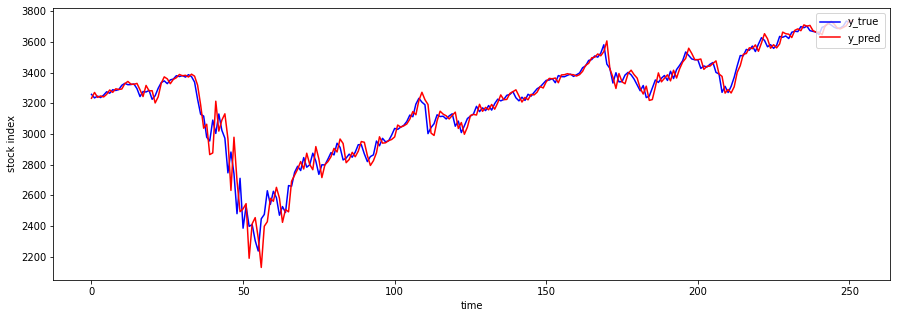

('MAE', 43.8441)

In [ ]:
pred_list,true_list=De_ARIMApipe_(test_startindex,True)

#----------------------------------------------
print('==================S&P 500 2020.01.01 to 2020.12.31 (with sentiment)====================')
eval_(pred_list,true_list) 

## 3.2 Dow Jones Industrial

In [21]:
data=load_stockindex_('^DJI')
train_,test_=holdtest_split_(data)
train_,test_=np.array(train_).reshape(-1),np.array(test_).reshape(-1)

test_startindex=-len(test_)
arr=np.concatenate([train_,test_],axis=0)
arr_logreturn=logreturn_(arr)

arr_sentiment=np.array(pd.merge(data, load_sentiment_(), 
                       how='left',left_index=True, right_index=True)['overall_sentiment'])

===========wavelet transform test part==========


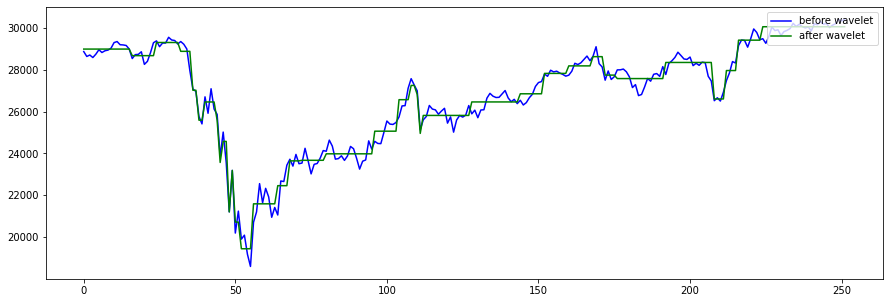

In [25]:
# denoised example--
print('===========wavelet transform test part==========')
test_wave_true=denoising_wavelet_(test_,'db1')

==================Dow Jones Industrial 2020.01.01 to 2020.12.31 (without sentiment)====================


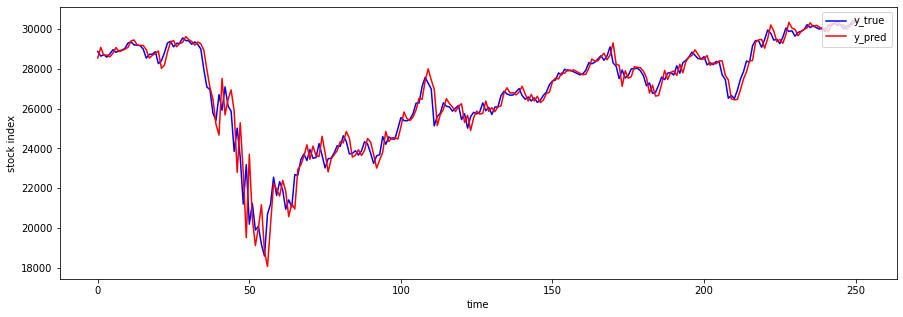

('MAE', 394.4704)

In [26]:
pred_list,true_list=De_ARIMApipe_(test_startindex,False)

#----------------------------------------------
print('==================Dow Jones Industrial 2020.01.01 to 2020.12.31 (without sentiment)====================')
pred_dearima_225=pred_list
eval_(pred_list,true_list) 

==================Dow Jones Industrial 2020.01.01 to 2020.12.31 (with sentiment)====================


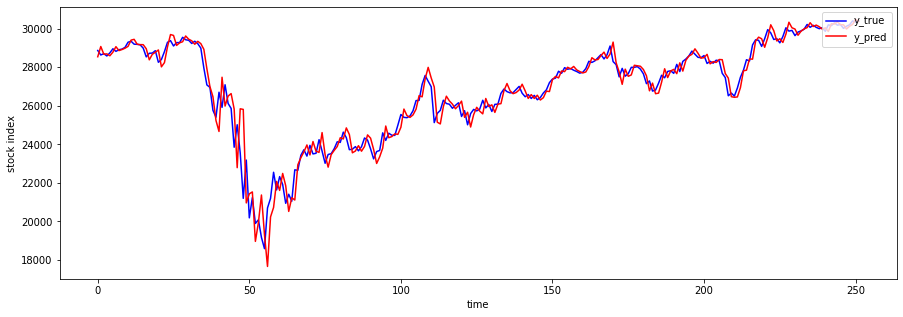

('MAE', 402.9173)

In [27]:
pred_list,true_list=De_ARIMApipe_(test_startindex,True)

#----------------------------------------------
print('==================Dow Jones Industrial 2020.01.01 to 2020.12.31 (with sentiment)====================')
eval_(pred_list,true_list) 

## 3.3 Nasdaq Composite

===========wavelet transform test part==========


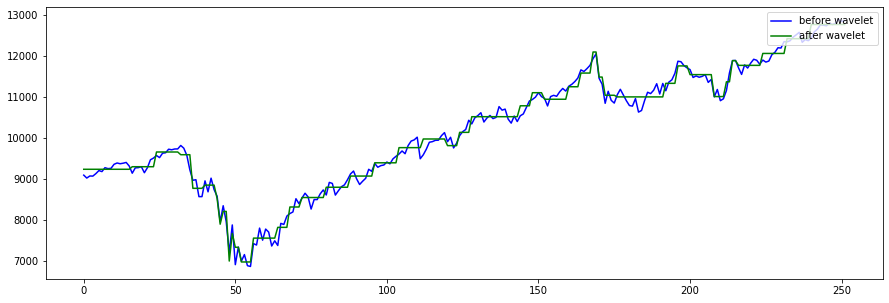

In [ ]:
data=load_stockindex_('^IXIC')
train_,test_=holdtest_split_(data)
train_,test_=np.array(train_).reshape(-1),np.array(test_).reshape(-1)

test_startindex=-len(test_)
arr=np.concatenate([train_,test_],axis=0)
arr_logreturn=logreturn_(arr)

arr_sentiment=np.array(pd.merge(data, load_sentiment_(), 
                       how='left',left_index=True, right_index=True)['overall_sentiment'])

# denoised example--
print('===========wavelet transform test part==========')
test_wave_true=denoising_wavelet_(test_,'db1')

==================Nasdaq 2020.01.01 to 2020.12.31 (without sentiment)====================


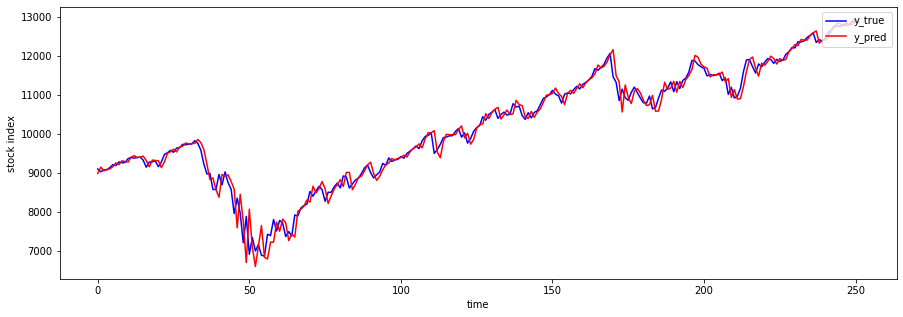

('MAE', 150.6115)

In [ ]:
pred_list,true_list=De_ARIMApipe_(test_startindex,False)

#----------------------------------------------
print('==================Nasdaq 2020.01.01 to 2020.12.31 (without sentiment)====================')
pred_dearima_com=pred_list
eval_(pred_list,true_list) 

==================Nasdaq 2020.01.01 to 2020.12.31 (with sentiment)====================


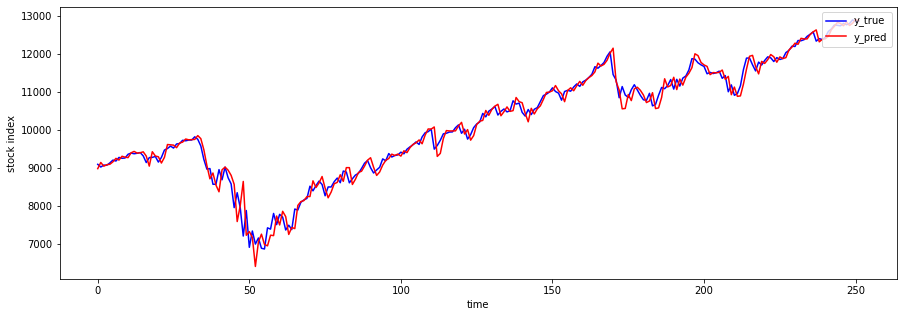

('MAE', 147.6022)

In [ ]:
pred_list,true_list=De_ARIMApipe_(test_startindex,True)

#----------------------------------------------
print('==================Nasdaq 2020.01.01 to 2020.12.31 (with sentiment)====================')
eval_(pred_list,true_list) 